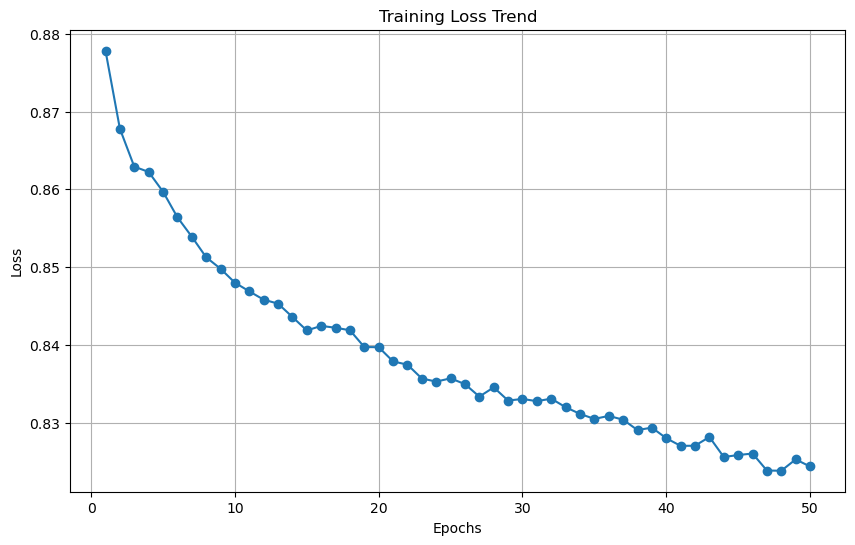

Best Threshold: 0.35 with F1 Score: 0.5562
Final Metrics at Threshold 0.35:
Accuracy: 0.5585
Precision: 0.4213
Recall: 0.8181
F1 Score: 0.5562


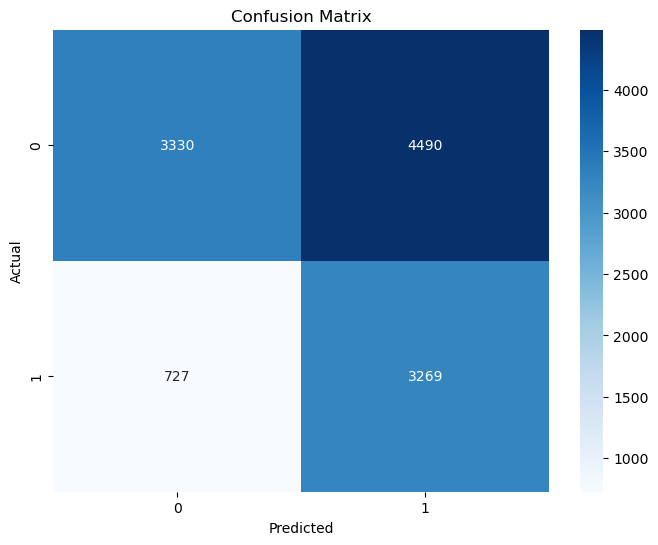

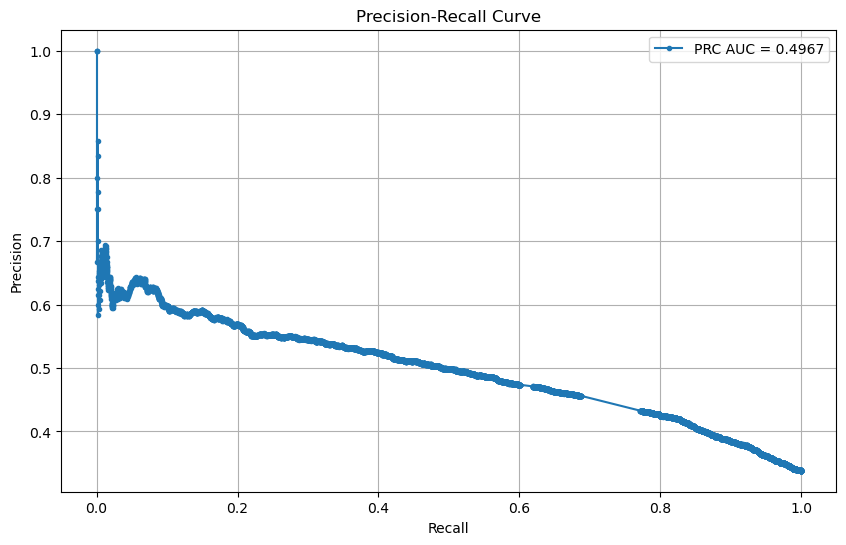

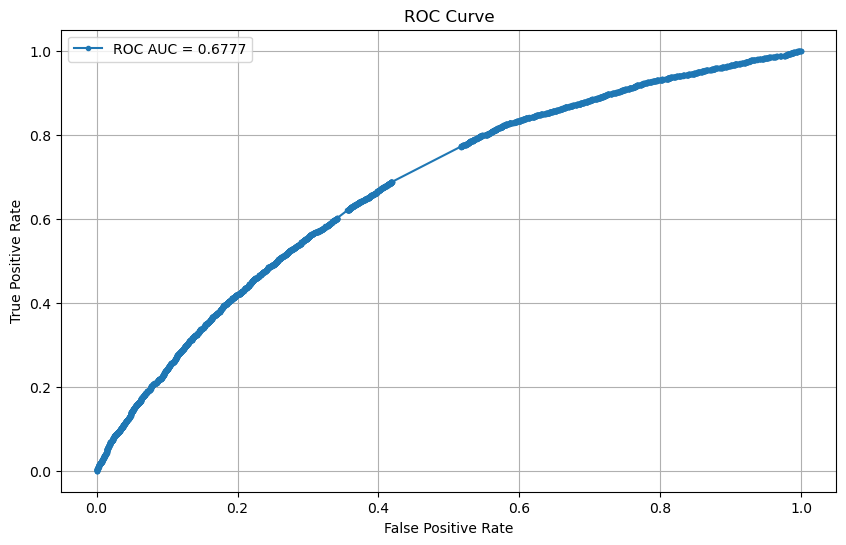

Total Number of Test Data: 102505
Number of Positive Flags in Test Data: 55454
Updated test data with predictions saved to testing_loan_data_with_predictions.csv


In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Dataset Class
class LoanDataset(Dataset):
    def __init__(self, data, target=None):
        self.features = torch.tensor(data.values, dtype=torch.float32)
        self.target = torch.tensor(target.values, dtype=torch.float32) if target is not None else None

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if self.target is not None:
            return self.features[idx], self.target[idx]
        else:
            return self.features[idx]

# Neural Network Model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

# Load the data
train_data = pd.read_csv("cleaned_training_dataset.csv", header=0, low_memory=False)
test_data = pd.read_csv("cleaned_testing_dataset.csv", header=0, low_memory=False)

# Drop highly correlated features
remove_cols = ["total_bc_limit", "percent_bc_gt_75", "internal_score"]
train_data = train_data.drop(columns=remove_cols)
test_data = test_data.drop(columns=[col for col in remove_cols if col in test_data.columns])

# Encode categorical features
categorical_cols = ['home_ownership', 'purpose']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    if col in test_data.columns:
        test_data[col] = le.transform(test_data[col])
    label_encoders[col] = le

# Fill missing values
train_data = train_data.fillna(train_data.median())
test_data = test_data.fillna(train_data.median())  # Align with training data

# Separate features and target
target = train_data['bad_flag']
features = train_data.drop(columns=['bad_flag'])

# Downsample the Majority Class
from sklearn.utils import resample

data_combined = pd.concat([features, target], axis=1)
majority = data_combined[data_combined['bad_flag'] == 0]
minority = data_combined[data_combined['bad_flag'] == 1]

# Downsample majority class
majority_downsampled = resample(majority, 
                                 replace=False,  # Sample without replacement
                                 n_samples=len(minority)*2,  # Match minority class size
                                 random_state=42)

# Combine minority and downsampled majority
balanced_data = pd.concat([minority, majority_downsampled])
features_balanced = balanced_data.drop(columns=['bad_flag'])
target_balanced = balanced_data['bad_flag']

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(features_balanced, target_balanced, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_data.drop(columns=['bad_flag'], errors='ignore'))  # Avoid bad_flag in test

# Convert data into PyTorch Dataset
train_dataset = LoanDataset(pd.DataFrame(X_train), pd.Series(y_train))
val_dataset = LoanDataset(pd.DataFrame(X_val), pd.Series(y_val))
test_dataset = LoanDataset(pd.DataFrame(X_test))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model Configuration
input_size = X_train.shape[1]
hidden_size = 32  # Increased number of neurons per layer
epochs = 50
learning_rate = 0.01

# Weighted Loss Function
pos_weight = torch.tensor([len(y_train) / sum(y_train) - 1], dtype=torch.float32)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Instantiate the model and optimizer
model = NeuralNet(input_size, hidden_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop and Loss Tracking
loss_history = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    loss_history.append(epoch_loss)
#    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

# Plot Loss Trend
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), loss_history, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Trend')
plt.grid()
plt.show()

# Model Evaluation
model.eval()
all_preds = []
all_labels = []
all_probs = []
with torch.no_grad():
    for features, labels in val_loader:
        outputs = model(features).squeeze()
        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).float()  # Default threshold
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        all_probs.extend(probs.tolist())

# Tune Threshold Based on F1 Score
best_threshold = 0.0
best_f1 = 0.0
thresholds = np.arange(0.1, 0.9, 0.01)
for threshold in thresholds:
    preds = [1 if p >= threshold else 0 for p in all_probs]
    f1 = f1_score(all_labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best Threshold: {best_threshold:.2f} with F1 Score: {best_f1:.4f}")

# Final Metrics with Best Threshold
final_preds = [1 if p >= best_threshold else 0 for p in all_probs]
accuracy = accuracy_score(all_labels, final_preds)
precision = precision_score(all_labels, final_preds)
recall = recall_score(all_labels, final_preds)
f1 = f1_score(all_labels, final_preds)

print(f"Final Metrics at Threshold {best_threshold:.2f}:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Tune Threshold and Plot PRC Curve
precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)
prc_auc = auc(recall, precision)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label=f'PRC AUC = {prc_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

# Plot ROC Curve
fpr, tpr, roc_thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='.', label=f'ROC AUC = {roc_auc:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


# Inference on Test Data
predictions = []
positive_count = 0
with torch.no_grad():
    for features in test_dataset:
        outputs = model(features).item()
        prediction = 1 if torch.sigmoid(torch.tensor(outputs)) >= best_threshold else 0
        predictions.append(prediction)
        positive_count += prediction

# Output Predictions Summary
print(f"Total Number of Test Data: {len(predictions)}")
print(f"Number of Positive Flags in Test Data: {positive_count}")

# Read the test data
test_data = pd.read_csv("testing_loan_data.csv", header=0, low_memory=False)

# Ensure the predictions align with the test data
test_data['Predicted_Bad_Flag'] = predictions

# Save the updated test_data DataFrame with predictions
output_file_path = "testing_loan_data_with_predictions.csv"
test_data.to_csv(output_file_path, index=False)

print(f"Updated test data with predictions saved to {output_file_path}")